## THIS NOTEBOOK PLOTS EVENTS WITH THE TRUE DATA, THE RECONSTRUCTED DATA, AND THE SIPM OUTPUT, WITH THE RECONSTRUCTED BLOBS HIGHLIGHTED

This is done for HPR events here, but that doesn't need to be the case.


### First, lets load everything

#### Sophronia first, process the data and convert into lowTh esmeralda data

In [1]:
import sys,os,os.path
sys.path.append("../../") # if you move files around, you need to adjust this!
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

#%load_ext autoreload
#%autoreload 2
#%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

import pandas as pd
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun

from IC.invisible_cities.evm.event_model                          import HitCollection

from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType

from IC.invisible_cities.reco import hits_functions as hif

from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod

import IC.invisible_cities.io.mcinfo_io as mcio

from collections import defaultdict

import matplotlib.cm as cm
from matplotlib.colors import Normalize



### fun relevant functions for sophronia conversion

In [2]:


def threshold_hits(threshold_charge, same_peak, hitc):
    """
    Applies a threshold to hits and redistributes the charge/energy.

    Parameters
    ----------
    threshold_charge : float
        minimum pes of a hit
    same_peak        : bool
        whether to reassign NN hits' energy only to the hits from the same peak

    Returns
    ----------
    A function that takes HitCollection as input and returns another object with
    only non NN hits of charge above threshold_charge.
    The energy of NN hits is redistributed among neighbors.
    """

    t = hitc.time
    thr_hits = hif.threshold_hits(hitc.hits, threshold_charge     )
    mrg_hits = hif.merge_NN_hits ( thr_hits, same_peak = same_peak)

    cor_hits = []
    for hit in mrg_hits:
        cluster = Cluster(hit.Q, xy(hit.X, hit.Y), hit.var, hit.nsipm)
        xypos   = xy(hit.Xpeak, hit.Ypeak)
        hit     = Hit(hit.npeak, cluster, hit.Z, hit.E, xypos, hit.Ec)
        cor_hits.append(hit)

    new_hitc      = HitCollection(hitc.event, t)
    new_hitc.hits = cor_hits
    return new_hitc





def hits_from_df (dst, skip_NN = False):
    """
    Function that transforms pandas DataFrame dst to HitCollection
    ------
    Parameters
    ------
    dst : pd.DataFrame
        DataFrame with obligatory columns :
                event, npeak, X, Y, Z,  Q, E
        If time, nsipm, Xrms, Yrms, Qc, Ec, track_id are not
        inside dst the default value is set to -1
        If Xpeak, Ypeak not in dst the default value is -1000
    ------
    Returns
    ------
    Dictionary {event_number : HitCollection}
    from here
    https://github.com/next-exp/IC/blob/v2-development/invisible_cities/io/hits_io.py#L16
    """
    all_events = {}
    times = getattr(dst, 'time', [-1]*len(dst))
    for (event, time) , df in dst.groupby(['event', times]):
        #pandas is not consistent with numpy dtypes so we have to change it by hand
        event = np.int32(event)
        hits  = []
        for i, row in df.iterrows():
            Q = getattr(row,'Q', row.E)
            if skip_NN and Q == NN:
                continue
            if hasattr(row, 'Xrms'):
                Xrms  = row.Xrms
                Xrms2 = Xrms**2
            else:
                Xrms = Xrms2 = -1
            if hasattr(row, 'Yrms'):
                Yrms  = row.Yrms
                Yrms2 = Yrms**2
            else:
                Yrms = Yrms2 = -1
            nsipm   = getattr(row, 'nsipm'   , -1   )     # for backwards compatibility
            Qc      = getattr(row, 'Qc'      , -1   )     # for backwards compatibility
            Xpeak   = getattr(row, 'Xpeak'   , -1000)     # for backwards compatibility
            Ypeak   = getattr(row, 'Ypeak'   , -1000)     # for backwards compatibility
            Ec      = getattr(row, 'Ec'      , -1   )     # for backwards compatibility
            trackID = getattr(row, 'track_id', -1   )     # for backwards compatibility
            Ep      = getattr(row, "Ep"      , -1   )     # for backwards compatibility

            hit = Hit(row.npeak            ,
                      Cluster(Q               ,
                              xy(row.X, row.Y),
                              xy(Xrms2, Yrms2),
                              nsipm = nsipm   ,
                              z     = row.Z   ,
                              E     = row.E   ,
                              Qc    = Qc      ),
                      row.Z                ,
                      row.E                ,
                      xy(Xpeak, Ypeak)     ,
                      s2_energy_c = Ec     ,
                      track_id    = trackID,
                      Ep          = Ep     )

            hits.append(hit)

        if len(hits):
            all_events[event] = HitCollection(event, time, hits=hits)

    return all_events

def hitc_to_df_(hitc):
    columns = defaultdict(list)
    for hit in hitc.hits:
        columns["event"   ].append(hitc.event)
        columns["time"    ].append(hitc.time)
        columns["npeak"   ].append(hit .npeak)
        columns["Xpeak"   ].append(hit .Xpeak)
        columns["Ypeak"   ].append(hit .Ypeak)
        columns["nsipm"   ].append(hit .nsipm)
        columns["X"       ].append(hit .X)
        columns["Y"       ].append(hit .Y)
        columns["Xrms"    ].append(hit .Xrms)
        columns["Yrms"    ].append(hit .Yrms)
        columns["Z"       ].append(hit .Z)
        columns["Q"       ].append(hit .Q)
        columns["E"       ].append(hit .E)
        columns["Qc"      ].append(hit .Qc)
        columns["Ec"      ].append(hit .Ec)
        columns["track_id"].append(hit .track_id)
        columns["Ep"      ].append(hit .Ep)
    return pd.DataFrame(columns)

def soph_to_lowTh(df, threshold = 5):
    '''
    Converts sophronia 'RECO/Events' to lowTh events via a rather convoluted process

    ------
    Parameters
    ------
    df : pd.DataFrame
        DataFrame with obligatory columns :
                event, npeak, X, Y, Z,  Q, E
    threshold: int
        value at which the threshold is set.
    ------
    Returns
    ------
    Dictionary {event_number : HitCollection}
    from here
    '''

    # safety check, to ensure you don't accidentally make a repeating dataframe
    


    # new parameters for threshold, this is silly but I'm copying previous convention
    pes = 1
    threshold = threshold * pes
    same_peak = True

    # convert sophronia RECO/Events to hit collection
    soph_hitc = hits_from_df(df)

    # collect the keys as the event numbers
    soph_hitc_list = list(soph_hitc.keys())

    print("Processing data...")
    # loop over all of these events
    j = 0
    for i in soph_hitc_list:
        j += 1

        if (len(soph_hitc_list)%j == 50): 
            print("{}/{}".format(j, len(soph_hitc_list)))
        # choose i'th event
        soph_hit_event = soph_hitc.get(i)

        # Apply threshold calculation
        soph_hitc_lowTh = threshold_hits(threshold, same_peak, soph_hit_event)

        # convert back to pandas dataframe using hitc_to_df
        soph_hdst_lowTh = hitc_to_df_(soph_hitc_lowTh)

        # check if pandas dataframe with all the events exists yet
        if 'full_soph_df' in locals() and isinstance(full_soph_df, pd.DataFrame):
            full_soph_df = pd.concat([full_soph_df, soph_hdst_lowTh])
        else:
            full_soph_df = soph_hdst_lowTh.copy(deep = True)
    
    return full_soph_df

        

In [29]:
# loading sophronia file
directory_full = f'../HPR/208Tl/PORT_1a/prod/'

soph_file = directory_full + 'sophronia/sophronia_53_208Tl.h5'
isaura_file = directory_full + 'isaura/isaura/isaura_53_208Tl.h5'

isa_hdst = dstio.load_dst(isaura_file, 'Tracking', 'Tracks')
soph_hdst = dstio.load_dst(soph_file, 'RECO', 'Events')#CHITS/lowTh

print("Isaura:")
display(isa_hdst)
print("")
print("Sophronia:")
display(soph_hdst)

Isaura:


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,2080000,0,0.437401,22.295695,13,2743,1,65.675,-0.325,229.781265,...,232.762631,82.824971,20.546554,235.280859,0.437182,0.435891,0.435673,7.750000,9.333333,4.566093
1,2080002,0,1.119910,47.088389,45,5577,3,-328.325,44.675,175.163864,...,198.258919,-297.928068,54.027712,177.203472,0.868524,0.208002,0.028591,9.500000,9.333333,4.323497
2,2080002,1,0.000288,0.000000,1,4,3,-272.325,53.675,194.449860,...,194.449860,-271.833500,54.185070,194.449860,0.000288,0.000288,0.000288,9.500000,9.333333,4.323497
3,2080002,2,0.000139,0.000000,1,2,3,-285.325,20.675,196.125015,...,196.125015,-284.860542,20.675000,196.125015,0.000139,0.000139,0.000139,9.500000,9.333333,4.323497
4,2080004,0,0.390564,16.044771,7,1989,2,-174.325,-341.325,821.951904,...,823.088071,-162.945812,-326.990267,830.187679,0.390564,0.390564,0.390564,9.947368,9.631579,4.938822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4012,2083606,1,0.190544,14.248824,8,1729,3,-122.325,-143.325,388.523315,...,390.811380,-110.020846,-132.167907,394.182916,0.190544,0.190544,0.190544,9.625000,9.272727,4.940129
4013,2083606,2,0.000070,0.000000,1,2,3,-242.325,-170.325,509.453369,...,509.453369,-242.325000,-169.829155,509.453369,0.000070,0.000070,0.000070,9.625000,9.272727,4.940129
4014,2083608,0,0.767404,35.053676,46,4382,1,-171.325,279.675,922.746582,...,943.776443,-141.638046,290.606991,924.686645,0.718822,0.365052,0.316639,8.400000,8.333333,4.333577
4015,2083610,0,1.995733,166.536488,108,7411,2,-261.325,-17.325,264.214172,...,377.675969,-228.540192,6.613879,268.661935,0.628380,0.285380,0.000000,9.583333,9.780488,4.907978



Sophronia:


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,2080000,2.080001e+12,0,79.178449,12.635942,1,85.525,23.325,0.0,0.0,228.951996,5.159420,1923.000000,-1.0,0.004984,-1,-1.0
1,2080000,2.080001e+12,0,79.178449,12.635942,1,69.975,7.775,0.0,0.0,229.781265,15.884058,870.508545,-1.0,0.002266,-1,-1.0
2,2080000,2.080001e+12,0,79.178449,12.635942,1,69.975,23.325,0.0,0.0,229.781265,14.434783,791.082581,-1.0,0.002046,-1,-1.0
3,2080000,2.080001e+12,0,79.178449,12.635942,1,85.525,7.775,0.0,0.0,229.781265,15.188406,832.384094,-1.0,0.002172,-1,-1.0
4,2080000,2.080001e+12,0,79.178449,12.635942,1,85.525,23.325,0.0,0.0,229.781265,8.521739,467.024658,-1.0,0.001211,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902461,2083610,2.083612e+12,0,-226.889978,-7.595709,1,-241.025,7.775,0.0,0.0,383.400238,8.985507,400.845184,-1.0,0.001095,-1,-1.0
902462,2083610,2.083612e+12,0,-226.889978,-7.595709,1,-225.475,7.775,0.0,0.0,383.400238,7.014493,312.917847,-1.0,0.000846,-1,-1.0
902463,2083610,2.083612e+12,0,-226.889978,-7.595709,1,-225.475,23.325,0.0,0.0,383.400238,13.797101,615.491272,-1.0,0.001655,-1,-1.0
902464,2083610,2.083612e+12,0,-226.889978,-7.595709,1,-209.925,23.325,0.0,0.0,383.400238,6.898551,307.745636,-1.0,0.000827,-1,-1.0


In [4]:
# collect lowTh data from sophronia
soph_lowTh = soph_to_lowTh(soph_hdst, threshold = 5)
display(soph_lowTh)

Processing data...
859/1768
1718/1768


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,2080000,2.080001e+12,0.0,79.178449,12.635942,1.0,85.525,23.325,0.0,0.0,228.951996,5.159420,1923.000000,-1,0.004984,-1,-1
1,2080000,2.080001e+12,0.0,79.178449,12.635942,1.0,69.975,7.775,0.0,0.0,229.781265,15.884058,870.508542,-1,0.002266,-1,-1
2,2080000,2.080001e+12,0.0,79.178449,12.635942,1.0,69.975,23.325,0.0,0.0,229.781265,14.434783,791.082599,-1,0.002046,-1,-1
3,2080000,2.080001e+12,0.0,79.178449,12.635942,1.0,85.525,7.775,0.0,0.0,229.781265,15.188406,832.384089,-1,0.002172,-1,-1
4,2080000,2.080001e+12,0.0,79.178449,12.635942,1.0,85.525,23.325,0.0,0.0,229.781265,8.521739,467.024648,-1,0.001211,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,2083610,2.083612e+12,0.0,-226.889978,-7.595709,1.0,-241.025,7.775,0.0,0.0,383.400238,8.985507,400.845163,-1,0.001095,-1,-1
1180,2083610,2.083612e+12,0.0,-226.889978,-7.595709,1.0,-225.475,7.775,0.0,0.0,383.400238,7.014493,312.917856,-1,0.000846,-1,-1
1181,2083610,2.083612e+12,0.0,-226.889978,-7.595709,1.0,-225.475,23.325,0.0,0.0,383.400238,13.797101,615.491280,-1,0.001655,-1,-1
1182,2083610,2.083612e+12,0.0,-226.889978,-7.595709,1.0,-209.925,23.325,0.0,0.0,383.400238,6.898551,307.745640,-1,0.000827,-1,-1


In [5]:
# loading MC
evtmap = mcio.load_eventnumbermap(soph_file).set_index('nexus_evt')
true_info = mcio.load_mchits_df(soph_file).reset_index()
true_info.event_id = true_info.event_id.map(evtmap.evt_number)
    

## Deconvolution stuff

In [22]:
# Input file and some event IDs to look at.
dist = 12
typefile = 'esmeralda' #'esmeralda'
#file = f'/Users/halmamol/NEXT/files/NEXT100/separated/esmeralda/esmeralda_10_sep.h5'
file = f'../LPR/208Tl/PORT_2a/prod/esmeralda/esmeralda_53_208Tl.h5'
#file = f'/Users/halmamol/NEXT/files/FLEX/ELdistMask/Xe/bb0nu/{typefile}/NextFlex.bb0nu.FLEXELdist{dist}mask.0.detsim.h5'
evts = [90] #15, 30, 90
pitch = 15.55
detector_db     = '../beersheba_parameter_testing/localdb.NEXT100DB.sqlite3'
run_number      = -1

datatype = 'MC'


# Parameters involved in beersheba city and the deconvolution.

'''
## FROM OLD TESTING
deconv_params = dict(
  q_cut           = 5, #5 for 6mm  - 5 for 6mm
  drop_dist       = [16, 16],
  #psf_fname       = f'/Users/halmamol/NEXT/PSF_FLEX100_mask{dist}_lowQE.h5',     
  psf_fname       = f'../data/data/LightTables/NEXT100_PSF_kr83m.h5',     
  e_cut           = 6e-3, #15 for 6mm  - 15 for 6mm
  n_iterations    = 100, #150 for 6mm  - 150 for 6mm
  iteration_tol   = 1e-10,
  sample_width    = [15.55, 15.55],
  bin_size        = [ 1,  1],
  diffusion       = (1., 0.2),
  n_dim           = 2,
  deconv_mode     = DeconvolutionMode.joint)#,
 # energy_type     = HitEnergy.Ec,
 # cut_type        = CutType.abs,
 # inter_method    = InterpolationMethod.cubic)
'''

# new parameters for threshold
pes = 1
threshold = 5 * pes
same_peak = True

deconv_params = dict(
                  drop_dist       = [16., 16.],
                  psf_fname       = f'../LPR//LightTables/NEXT100_PSF_kr83m_5bar.h5',
                  q_cut           = 10,                   # WE HAVE MANUALLY CHANGED THIS FROM 10 -> 5 HERE
                  e_cut           = 12e-3,                # WE HAVE MANUALLY CHANGED THIS FROM 12e-3 TO 6e-3
                  n_iterations    = 100,
                  iteration_tol   = 1e-10,
                  sample_width    = [15.55, 15.55],
                  bin_size        = [ 1.,  1.],
                  energy_type     = HitEnergy.Ec,               #Removing these variables because they were previously? 
                  diffusion       = (1., 0.2),
                  deconv_mode     = DeconvolutionMode.joint,
                  n_dim           = 2,
                  cut_type        = CutType.abs,              #Removing these variables because they were previously?
                  inter_method    = InterpolationMethod.cubic)            #Removing these variables because they were previously?  




#DeconvolutionMode
                
deconv_params_   = {k : v for k, v in deconv_params.items() if k not in ['q_cut', 'drop_dist']}

# Couple of functions used in beersheba.
cut_sensors       = beerfun.cut_over_Q   (deconv_params['q_cut'    ], ['E', 'Ec'])
drop_sensors      = beerfun.drop_isolated(deconv_params['drop_dist'], ['E', 'Ec'])

In [7]:
deconv_params


{'drop_dist': [16.0, 16.0],
 'psf_fname': '../LPR//LightTables/NEXT100_PSF_kr83m_5bar.h5',
 'q_cut': 10,
 'e_cut': 0.012,
 'n_iterations': 100,
 'iteration_tol': 1e-10,
 'sample_width': [15.55, 15.55],
 'bin_size': [1.0, 1.0],
 'energy_type': <HitEnergy.Ec: 'Ec'>,
 'diffusion': (1.0, 0.2),
 'deconv_mode': <DeconvolutionMode.joint: 'joint'>,
 'n_dim': 2,
 'cut_type': <CutType.abs: 'abs'>,
 'inter_method': <InterpolationMethod.cubic: 'cubic'>}

In [8]:
# data renaming for convention
hdst = soph_lowTh

Choosing an event

In [16]:
evt  = hdst.event.unique()[20]
print(evt)
hits = hdst[hdst.event == evt]

file_number = soph_file.split('sophronia_')[1].split('_208Tl')[0]
no = evt

dir_name = "Th208_" + file_number + "_event_" + str(no)

2080040


In [11]:
this_evt_true_info = true_info[true_info.event_id == evt]

xt = this_evt_true_info.x
yt = this_evt_true_info.y
zt = this_evt_true_info.z
et = this_evt_true_info.energy*1000

Collect x,y,z range of the hits

In [10]:
x_range = (hits.X.max()-hits.X.min())/2.
y_range = (hits.Y.max()-hits.Y.min())/2.
z_range = (hits.Z.max()-hits.Z.min())/2.
mid_x   = (hits.X.max()+hits.X.min())/2.
mid_y   = (hits.Y.max()+hits.Y.min())/2.
mid_z   = (hits.Z.max()+hits.Z.min())/2.

print("X maximum and minimum")
print(hits.X.max(), hits.X.min())
print("")

print("Y maximum and minimum")
print(hits.Y.max(), hits.Y.min())
print("")

print("Z maximum and minimum")
print(hits.Z.max(), hits.Z.min())

xbins = int(hits.X.max()-hits.X.min())
ybins = int(hits.Y.max()-hits.Y.min())
zbins = int((hits.Z.max()-hits.Z.min())/2.)

X maximum and minimum
132.175 38.875

Y maximum and minimum
256.575 178.825

Z maximum and minimum
443.8947448730469 398.60833740234375


In [12]:
display(evtmap)
print("true:")
display(true_info)
print("soph:")
display(soph_lowTh)
#true_info.head()
display(this_evt_true_info.head())

,evt_number
nexus_evt,
1040000,2080000
1040001,2080002
1040002,2080004
1040003,2080006
1040004,2080008
...,...
1041801,2083602
1041802,2083604
1041803,2083606


true:


,event_id,particle_id,hit_id,x,y,z,time,energy,label
0,2080000,6,0,80.889832,9.769197,230.675903,1.957200,0.000164,ACTIVE
1,2080000,21,0,80.889847,9.769242,230.675903,1.957212,0.000044,ACTIVE
2,2080000,20,0,80.889793,9.769176,230.675873,1.957215,0.000045,ACTIVE
3,2080000,19,0,80.889847,9.769156,230.675873,1.957214,0.000047,ACTIVE
4,2080000,18,0,80.889870,9.769136,230.675903,1.957226,0.000023,ACTIVE
...,...,...,...,...,...,...,...,...,...
331802,2083610,55,1,-248.055450,5.064333,275.233063,2.711109,0.002764,ACTIVE
331803,2083610,55,2,-248.055374,5.064343,275.233093,2.711120,0.000145,ACTIVE
331804,2083610,54,0,-248.051834,5.065635,275.234406,2.711120,0.000942,ACTIVE
331805,2083610,54,1,-248.046860,5.070758,275.234894,2.711253,0.003922,ACTIVE


soph:


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,2080000,2.080001e+12,0.0,79.178449,12.635942,1.0,85.525,23.325,0.0,0.0,228.951996,5.159420,1923.000000,-1,0.004984,-1,-1
1,2080000,2.080001e+12,0.0,79.178449,12.635942,1.0,69.975,7.775,0.0,0.0,229.781265,15.884058,870.508542,-1,0.002266,-1,-1
2,2080000,2.080001e+12,0.0,79.178449,12.635942,1.0,69.975,23.325,0.0,0.0,229.781265,14.434783,791.082599,-1,0.002046,-1,-1
3,2080000,2.080001e+12,0.0,79.178449,12.635942,1.0,85.525,7.775,0.0,0.0,229.781265,15.188406,832.384089,-1,0.002172,-1,-1
4,2080000,2.080001e+12,0.0,79.178449,12.635942,1.0,85.525,23.325,0.0,0.0,229.781265,8.521739,467.024648,-1,0.001211,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,2083610,2.083612e+12,0.0,-226.889978,-7.595709,1.0,-241.025,7.775,0.0,0.0,383.400238,8.985507,400.845163,-1,0.001095,-1,-1
1180,2083610,2.083612e+12,0.0,-226.889978,-7.595709,1.0,-225.475,7.775,0.0,0.0,383.400238,7.014493,312.917856,-1,0.000846,-1,-1
1181,2083610,2.083612e+12,0.0,-226.889978,-7.595709,1.0,-225.475,23.325,0.0,0.0,383.400238,13.797101,615.491280,-1,0.001655,-1,-1
1182,2083610,2.083612e+12,0.0,-226.889978,-7.595709,1.0,-209.925,23.325,0.0,0.0,383.400238,6.898551,307.745640,-1,0.000827,-1,-1


,event_id,particle_id,hit_id,x,y,z,time,energy,label
3156,2080040,6,0,88.271011,220.197189,433.355347,1.239294,0.000220,ACTIVE
3157,2080040,25,0,88.271034,220.197220,433.355316,1.239305,0.000044,ACTIVE
3158,2080040,24,0,88.270996,220.197189,433.355316,1.239302,0.000046,ACTIVE
3159,2080040,23,0,88.271004,220.197189,433.355347,1.239298,0.000047,ACTIVE
3160,2080040,22,0,88.271004,220.197205,433.355347,1.239299,0.000047,ACTIVE


Text(0.5, 0.98, 'True Hits_Th208_53_event_2080040')

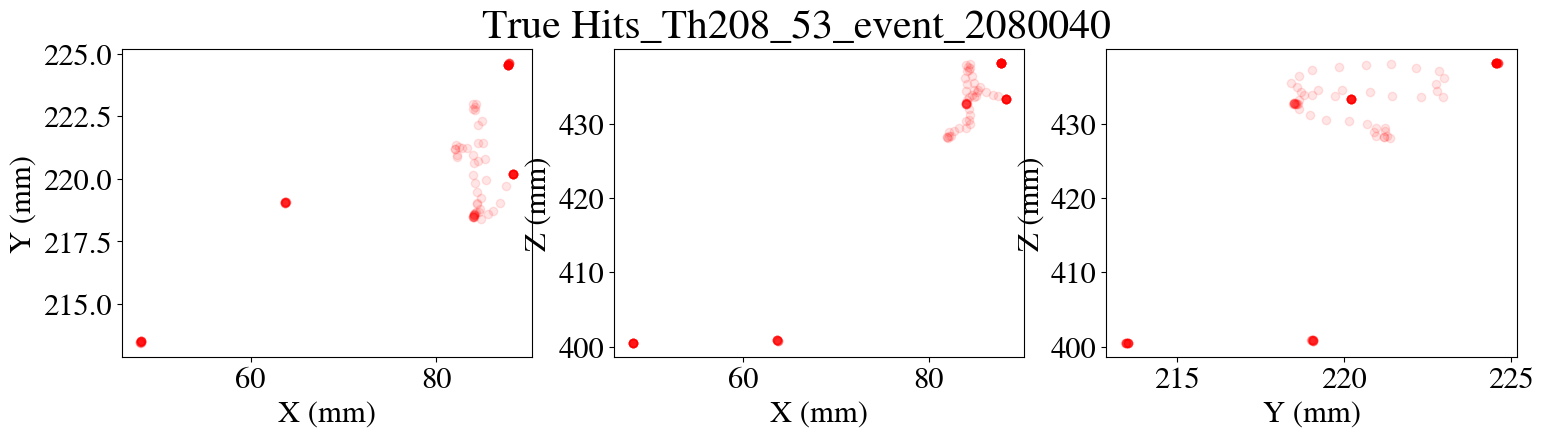

In [17]:
# plot true data
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
axes[0].scatter(xt, yt,  alpha=0.1, color='red')
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].scatter(xt, zt,  alpha=0.1, color='red')
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].scatter(yt, zt,  alpha=0.1, color='red')
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

fig.suptitle('True Hits_' + dir_name, fontsize=30)
#fig.savefig(pre_dir_name + dir_name + "/MC_hits")

Text(0.5, 0.98, 'Sensors Signal_Th208_53_event_2080040')

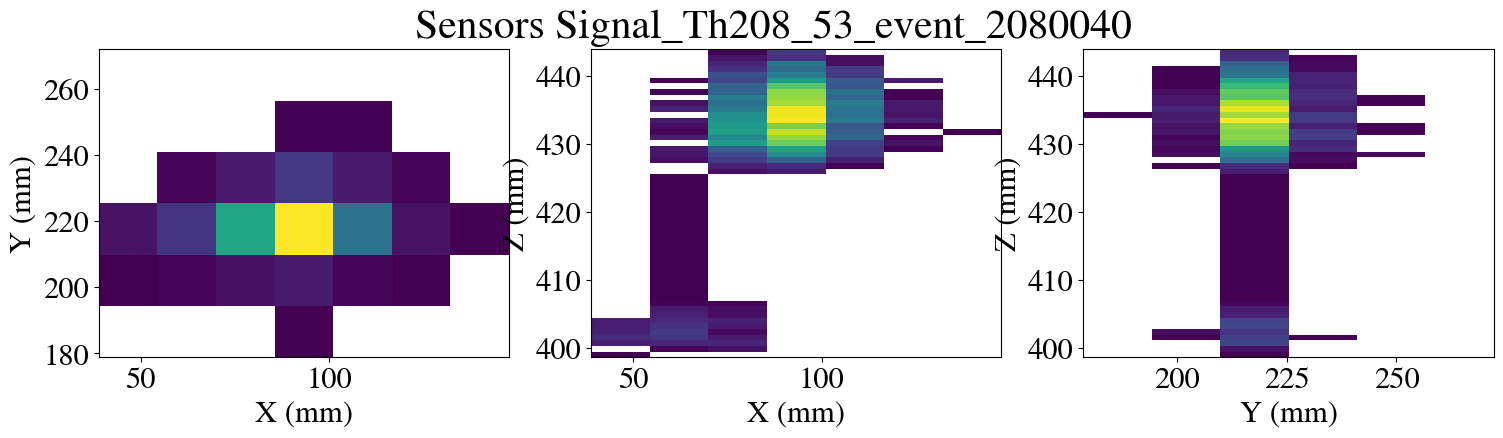

In [18]:
# plot SiPM outputs
fig, axes = plt.subplots(1, 3, figsize=(18, 4))


xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits.X, hits.Y, bins=[xx, yy], weights=hits.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits.X, hits.Z, bins=[xx, zz], weights=hits.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits.Y, hits.Z, bins=[yy, zz], weights=hits.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

fig.suptitle('Sensors Signal_' + dir_name, fontsize=30)
#fig.savefig(pre_dir_name + dir_name +  "/sensor_signal")

In [23]:
# cut sensors
qmin = deconv_params['q_cut']
print(f'Cutting sensors below {qmin}')
hits_cut = coref.timefunc(cut_sensors)(hits.copy())

# drop isolated sensors
hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())

# deconvolve
deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())

# this is to stop your number of iterations vanishing because of the below function, as you're rewriting deconv_params_
if 'save_state' in locals():
    deconv_params_['n_iterations'] = save_state
else:
    # first time round, so set it
    save_state = deconv_params_['n_iterations']



for iterN in np.arange(15, deconv_params_['n_iterations'], 15):
    deconv_params_['n_iterations'] = iterN
    deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
    print(f'{iterN} iterations')
    hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())

Cutting sensors below 10
Time spent in cut_over_Q: 0.01665520668029785 s
Time spent in drop_isolated: 0.013947010040283203 s
Time spent in apply_deconvolution: 2.131648540496826 s
100
15 iterations
Time spent in apply_deconvolution: 0.5043528079986572 s
30 iterations
Time spent in apply_deconvolution: 0.7972476482391357 s
45 iterations
Time spent in apply_deconvolution: 1.0740718841552734 s
60 iterations
Time spent in apply_deconvolution: 1.3996388912200928 s
75 iterations
Time spent in apply_deconvolution: 1.6527202129364014 s
90 iterations
Time spent in apply_deconvolution: 2.075401782989502 s


Text(0.5, 0.98, 'deconvolved_with_MC_Th208_53_event_2080040')

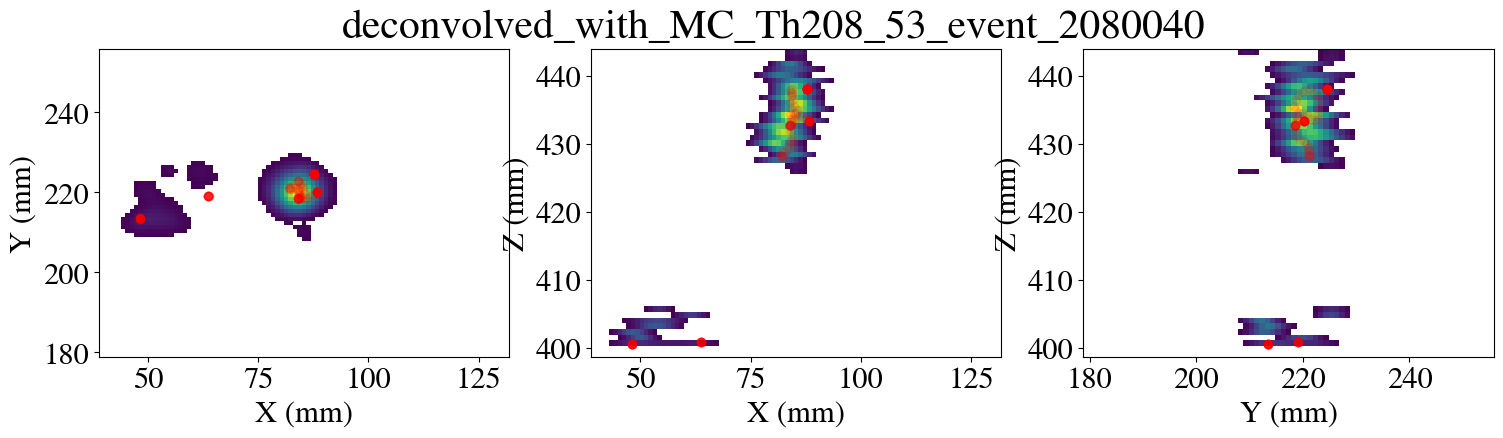

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max())
yy = np.arange(hits.Y.min(), hits.Y.max())
zz = hits.Z.unique()

axes[0].hist2d(hits_deco.X, hits_deco.Y, bins=[xx, yy], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_deco.X, hits_deco.Z, bins=[xx, zz], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].hist2d(hits_deco.Y, hits_deco.Z, bins=[yy, zz], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');


fig.suptitle('deconvolved_with_MC_' + dir_name, fontsize=30)
#fig.savefig(pre_dir_name + dir_name +  "/deconvolved_w_MC")

In [32]:
### Now from isaura, add blob positions

isa_interest = isa_hdst[isa_hdst.event == evt]
display(isa_interest)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
39,2080040,0,0.520005,20.581754,11,2709,2,77.675,212.675,425.488251,...,440.619128,83.598133,224.233095,427.866099,0.520005,0.520005,0.520005,9.166667,9.75,4.846761
40,2080040,1,0.065742,18.333333,5,588,2,40.675,212.675,400.273895,...,401.717060,63.046842,220.136611,403.856291,0.065680,0.065253,0.065191,9.166667,9.75,4.846761
